In [2]:
import json

with open('arraysPartidasResultado.json') as file:
    data_results = json.load(file)

with open('caracteristicas_campeones.json') as file:
    data_champions = json.load(file)



In [3]:
import pandas as pd

# Transformamos la lista de campeones en un diccionario para facilitar el acceso a sus características por clave
champions_features = {champ['Key']: champ for champ in data_champions}
# Calculamos las medias de las características
features_to_average = ['Difficulty', 'HP', 'Armor', 'HPRegen', 'AttackDamage', 'AttackSpeed']
average_features = {feature: sum(champ[feature] for champ in champions_features.values()) / len(champions_features) for feature in features_to_average}
# Crear un DataFrame vacío para almacenar los datos combinados
combined_data = []

# Iteramos sobre cada partida en data_results
for match in data_results:
    # Extrayendo el resultado del partido y los IDs de los campeones
    match_result = match[0]
    champion_ids = match[1:]

    # Lista para almacenar las características combinadas de los campeones de la partida
    match_features = []

    # Sumar características de todos los campeones en la partida
    for champ_id in champion_ids:
        # Si el campeón está en nuestro diccionario de características, agregamos sus datos
        if champ_id in champions_features:
            champ_data = champions_features[champ_id]
            match_features.extend([
                champ_data['Difficulty'],
                champ_data['HP'],
                champ_data['Armor'],
                champ_data['HPRegen'],
                champ_data['AttackDamage'],
                champ_data['AttackSpeed']
            ])
        else:

            # Usamos las medias si el campeón no está en el diccionario
            match_features.extend([average_features[feat] for feat in features_to_average])

    # Agregamos el resultado del partido y las características acumuladas a los datos combinados
    combined_data.append([match_result] + match_features)

# Convertimos la lista combinada en un DataFrame para su manipulación y visualización
column_names = ['Result'] + [f'Champ{i}_{feat}' for i in range(1, 11)
                             for feat in ['Difficulty', 'HP', 'Armor', 'HPRegen', 'AttackDamage', 'AttackSpeed']]
df_combined = pd.DataFrame(combined_data, columns=column_names)

# Mostramos las primeras filas del DataFrame para verificar
df_combined.head()


,Result,Champ1_Difficulty,Champ1_HP,Champ1_Armor,Champ1_HPRegen,Champ1_AttackDamage,Champ1_AttackSpeed,Champ2_Difficulty,Champ2_HP,Champ2_Armor,...,Champ9_Armor,Champ9_HPRegen,Champ9_AttackDamage,Champ9_AttackSpeed,Champ10_Difficulty,Champ10_HP,Champ10_Armor,Champ10_HPRegen,Champ10_AttackDamage,Champ10_AttackSpeed
0,1,8.0,630.0,33.0,8.5,64.0,0.625,7.0,655.0,27.0,...,29.835366,6.41311,58.920732,0.649543,3.0,610.0,47.0,8.5,55.0,0.644
1,0,8.0,596.0,22.0,5.5,55.0,0.625,7.0,600.0,20.0,...,28.000000,3.50000,50.000000,0.625000,5.0,575.0,27.0,9.0,61.0,0.645
2,1,4.0,650.0,40.0,6.0,64.0,0.658,5.0,670.0,38.0,...,29.000000,3.75000,62.000000,0.679000,5.0,610.0,30.0,5.0,62.0,0.635
3,0,3.0,660.0,35.0,8.0,69.0,0.665,7.0,658.0,30.0,...,29.835366,6.41311,58.920732,0.649543,5.0,610.0,30.0,5.0,62.0,0.635
4,0,3.0,660.0,35.0,8.0,69.0,0.665,8.0,558.0,19.0,...,24.000000,4.00000,62.000000,0.625000,4.0,646.0,35.0,8.5,68.0,0.644


In [4]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Separar los datos en variables independientes (X) y la variable dependiente (y)
X = df_combined.iloc[:, 1:].values  # Todas las filas, todas las columnas excepto la primera
y = df_combined.iloc[:, 0].values  # Todas las filas, solo la primera columna (resultado del partido)

# Normalizar las características
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Guardar el scaler para su uso posterior
joblib.dump(scaler, 'scaler.gz')
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Mostramos las dimensiones de los conjuntos de entrenamiento y prueba para confirmar
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)


(((11026, 60), (11026,)), ((2757, 60), (2757,)))

In [9]:
from keras.models import Sequential
from keras.layers import Dense

# Creación del modelo de Perceptrón Multicapa
model = Sequential ( )

model . add (Dense (200 , activation = 'relu' , input_dim = 60) )

model . add (Dense ( 1 , activation = 'sigmoid') )

# Compilación del modelo
model.compile(optimizer='rmsprop',                 # Optimizador
              loss='binary_crossentropy',       # Función de pérdida
              metrics=['accuracy'])             # Métrica de evaluación

# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=150, batch_size=128, validation_split=0.1, verbose=1)
model.save('perceptron_multicapa.h5')

train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Evaluación del modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=128)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)



C:\Users\USUARIO\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5246 - loss: 0.6950 - val_accuracy: 0.5077 - val_loss: 0.6951
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5345 - loss: 0.6891 - val_accuracy: 0.5567 - val_loss: 0.6841
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5526 - loss: 0.6849 - val_accuracy: 0.5095 - val_loss: 0.6963
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - accuracy: 0.5460 - loss: 0.6864 - val_accuracy: 0.5603 - val_loss: 0.6837
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5473 - loss: 0.6877 - val_accuracy: 0.5159 - val_loss: 0.6920
Epoch 6/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5557 - loss: 0.6854 - val_accuracy: 0.5639 - val_loss: 0.6823
Epoch 7/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5578 - loss: 0.6835 - val_accuracy: 0.5539 - val_loss: 0.6850
Epoch 8/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5604 - loss: 0.6805 - val_accuracy: 0.5675 -

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.6482 - loss: 0.6483
Test Loss: 0.6307434439659119
Test Accuracy: 0.6644904017448425


In [12]:
from keras.models import Sequential
from keras.layers import Dense

# Creación del modelo de Perceptrón Multicapa
model = Sequential()

# Capa de entrada y primera capa oculta con 200 neuronas
model.add(Dense(200, activation='relu', input_dim=60))

# Nueva capa oculta con 100 neuronas
model.add(Dense(200, activation='relu'))  # Capa oculta adicional

# Capa de salida
model.add(Dense(1, activation='sigmoid'))

# Compilación del modelo
model.compile(optimizer='rmsprop',              # Optimizador
              loss='binary_crossentropy',        # Función de pérdida
              metrics=['accuracy'])              # Métrica de evaluación

# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=150, batch_size=128, validation_split=0.1, verbose=1)
model.save('perceptron_multicapa.h5')

train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Evaluación del modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=128)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/150


C:\Users\USUARIO\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5280 - loss: 0.6976 - val_accuracy: 0.5394 - val_loss: 0.6903
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5396 - loss: 0.6883 - val_accuracy: 0.5567 - val_loss: 0.6855
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5435 - loss: 0.6875 - val_accuracy: 0.5549 - val_loss: 0.6834
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5500 - loss: 0.6849 - val_accuracy: 0.5549 - val_loss: 0.6829
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5564 - loss: 0.6844 - val_accuracy: 0.5503 - val_loss: 0.6818
Epoch 6/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5630 - loss: 0.6819 - val_accuracy: 0.5612 - val_loss: 0.6791
Epoch 7/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5707 - loss: 0.6779 - val_accuracy: 0.4678 - val_loss: 0.7102
Epoch 8/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5816 - loss: 0.6752 - val_accuracy: 0.5549 - val_loss: 0.6

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.7682 - loss: 0.8193
Test Loss: 0.8034132122993469
Test Accuracy: 0.7751178741455078


In [15]:
from keras.models import Sequential
from keras.layers import Dense

# Creación del modelo de Perceptrón Multicapa
model = Sequential()

# Capa de entrada y primera capa oculta con 200 neuronas
model.add(Dense(200, activation='relu', input_dim=60))

# Nueva capa oculta con 100 neuronas y activación sigmoid
model.add(Dense(50, activation='sigmoid'))  # Cambio de 'relu' a 'sigmoid'

# Capa de salida
model.add(Dense(1, activation='sigmoid'))

# Compilación del modelo
model.compile(optimizer='rmsprop',              # Optimizador
              loss='binary_crossentropy',        # Función de pérdida
              metrics=['accuracy'])              # Métrica de evaluación

# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=150, batch_size=128, validation_split=0.1, verbose=1)
model.save('perceptron_multicapa.h5')

train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Evaluación del modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=128)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/150


C:\Users\USUARIO\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5342 - loss: 0.6942 - val_accuracy: 0.5349 - val_loss: 0.6915
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5463 - loss: 0.6884 - val_accuracy: 0.5549 - val_loss: 0.6867
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5368 - loss: 0.6888 - val_accuracy: 0.5521 - val_loss: 0.6856
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5445 - loss: 0.6857 - val_accuracy: 0.5277 - val_loss: 0.6923
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5628 - loss: 0.6846 - val_accuracy: 0.5530 - val_loss: 0.6904
Epoch 6/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5566 - loss: 0.6841 - val_accuracy: 0.5530 - val_loss: 0.6866
Epoch 7/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5556 - loss: 0.6852 - val_accuracy: 0.5594 - val_loss: 0.6842
Epoch 8/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5583 - loss: 0.6822 - val_accuracy: 0.5476 - val_loss: 0.6

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.6835 - loss: 0.6528
Test Loss: 0.6454055309295654
Test Accuracy: 0.6938701272010803


In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Creación del modelo de Perceptrón Multicapa
model = Sequential()

# Capa de entrada y primera capa oculta con 200 neuronas
model.add(Dense(200, activation='relu', input_dim=60))
model.add(Dropout(0.5))  # Capa de Dropout para reducir el sobreajuste


# Capa de salida
model.add(Dense(1, activation='sigmoid'))

# Compilación del modelo
model.compile(optimizer='rmsprop',              # Optimizador
              loss='binary_crossentropy',        # Función de pérdida
              metrics=['accuracy'])              # Métrica de evaluación

# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=150, batch_size=128, validation_split=0.1, verbose=1)
model.save('perceptron_multicapa.h5')

train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Evaluación del modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=128)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/150


C:\Users\USUARIO\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5152 - loss: 0.7138 - val_accuracy: 0.5503 - val_loss: 0.6858
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5353 - loss: 0.6921 - val_accuracy: 0.4542 - val_loss: 0.7005
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5540 - loss: 0.6875 - val_accuracy: 0.5440 - val_loss: 0.6903
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5362 - loss: 0.6887 - val_accuracy: 0.5675 - val_loss: 0.6849
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5568 - loss: 0.6856 - val_accuracy: 0.5567 - val_loss: 0.6836
Epoch 6/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5519 - loss: 0.6862 - val_accuracy: 0.5367 - val_loss: 0.6854
Epoch 7/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5456 - loss: 0.6865 - val_accuracy: 0.5549 - val_loss: 0.6842
Epoch 8/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5517 - loss: 0.6841 - val_accuracy: 0.5494 - val_loss: 0.6

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.6315 - loss: 0.6580
Test Loss: 0.6484514474868774
Test Accuracy: 0.6329343318939209


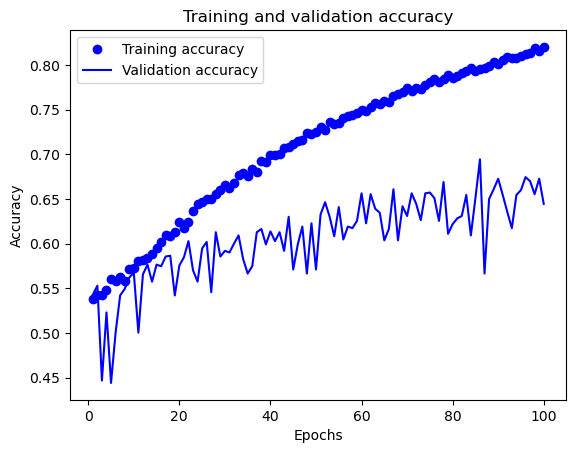

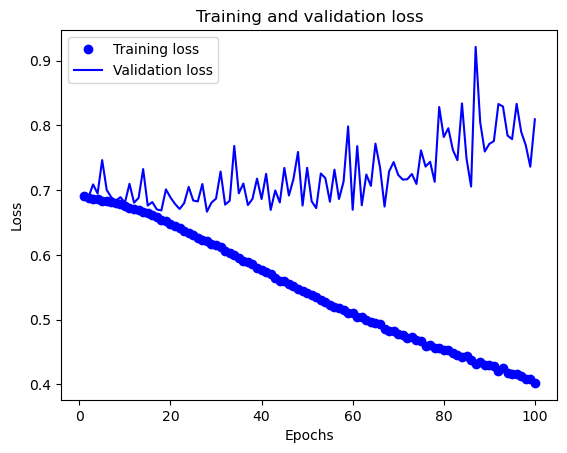

In [45]:
    import matplotlib.pyplot as plt

# Extraer la precisión y pérdida del historial de entrenamiento
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Graficar la precisión
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

# Graficar la pérdida
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [27]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model



# Cargar un modelo previamente entrenado
model = load_model('perceptron_multicapa.h5')  

scaler_loaded = joblib.load('scaler.gz') # 
model.evaluate(X_test, y_test)  # Esto inicializará las métricas
def recommend_champion_for_team1(current_match, available_champions, champions_features, model, scaler):
    team1 = current_match[:5]  # Los primeros 5 son del equipo 1
    team2 = current_match[5:]  # Los siguientes 5 son del equipo 2

    best_champion = None
    highest_win_probability = 0

    # Iterar sobre campeones disponibles que no están en el partido actual
    for champ in available_champions:
        # Probar añadir este campeón al equipo 1
        test_team1 = team1 + [champ]
        # Asegurarse de que la lista no exceda 5 campeones
        if len(test_team1) > 5:
            test_team1 = test_team1[1:]  # Eliminar el primer campeón si se excede

        # Reunir las características para el modelo
        match_features = []
        for champ_id in test_team1 + team2:
            champ_data = champions_features.get(champ_id, None)
            if champ_data:
                champ_features = [
                    champ_data['Difficulty'],
                    champ_data['HP'],
                    champ_data['Armor'],
                    champ_data['HPRegen'],
                    champ_data['AttackDamage'],
                    champ_data['AttackSpeed']
                ]
                match_features.extend(champ_features)
            else:
                match_features.extend([0]*6)  # Asumir valores por defecto

        if len(match_features) != 60:
            continue  # Si no se cumplen las 60 características, omitir esta iteración

        # Escalar y predecir la probabilidad de ganar
        match_features = np.array(match_features).reshape(1, -1)
        match_features = scaler.transform(match_features)
        win_probability = model.predict(match_features)[0][0]

        # Actualizar el mejor campeón si la probabilidad de ganar es mayor
        if win_probability > highest_win_probability:
            best_champion = champ
            highest_win_probability = win_probability

    return best_champion, highest_win_probability



# Ejemplo de uso
# Lista de IDs de campeones disponibles
current_match = [104, 221, 117, 141, 82, 20, 523, 34, 41]

available_champions_keys = {champ['Key'] for champ in data_champions}

# Conjunto de IDs de campeones actualmente seleccionados
current_match_set = set(current_match)

# Realizando la diferencia de conjuntos para obtener los IDs disponibles
available_champions = list(available_champions_keys - current_match_set)

champion, probability = recommend_champion_for_team1(current_match, available_champions, champions_features, model, scaler)
print(f"Add champion {champion} to Team 1 to increase win probability to {probability:.2%}")




87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.6013 - loss: 0.7644 
Add champion None to Team 1 to increase win probability to 0.00%
